**Last Updated**: *27 May 2025*

**Part I: Preparing data**

In [1]:
# === Modules ===
import numpy as np
import torch
import torch.nn as nn # nn models
import torch.optim as optim # optimization algorithms (incl. stocastic gradient descend)
import torch.nn.functional as F # activation functions (incl. ReLu)
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split, ConcatDataset, WeightedRandomSampler # dataset management
from torchvision.transforms import v2 # transformations (inc. random rotation)
import random
import time
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import copy
from tqdm import tqdm
from collections import OrderedDict
from scipy.signal import savgol_filter

In [2]:
# === Functions: Spliting & Data augmentation ===

# Data spliting 
def split_dataset(base_dataset, cd_ids, val_perc=0.2, test_perc=0.2, random_seed=42):
    
    id_to_indices = {id_: [] for id_ in np.unique(cd_ids)}
    for i, id_ in enumerate(cd_ids):
        id_to_indices[id_].append(i)
    random.seed(random_seed)
    id_list = list(id_to_indices.keys())
    random.shuffle(id_list)

    n = len(id_list)
    val_n = int(val_perc * n)
    test_n = int(test_perc * n)

    val_ids = id_list[:val_n]
    test_ids = id_list[val_n:val_n + test_n]
    train_ids = id_list[val_n + test_n:]

    val_idx = [i for id_ in val_ids for i in id_to_indices[id_]]
    test_idx = [i for id_ in test_ids for i in id_to_indices[id_]]
    train_idx = [i for id_ in train_ids for i in id_to_indices[id_]]

    return Subset(base_dataset, train_idx), Subset(base_dataset, val_idx), Subset(base_dataset, test_idx)

# Data augmentation
augment_transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),         # horizontal flip with a prob of 50%
    v2.RandomVerticalFlip(p=0.5),           # vertival flip with a prob of 50%
    v2.RandomRotation(degrees=(90, 270))])  # random rotation between 90° and 270°  

class augment_dataset():
    def __init__(self, base_dataset, transform, n_augments=5):
        self.base_dataset = base_dataset
        self.transform = transform
        self.n_augments = n_augments

    def __len__(self):
        return len(self.base_dataset) * (1 + self.n_augments)

    def __getitem__(self, idx):
        base_idx = idx // (1 + self.n_augments)  
        augmentation_idx = idx % (1 + self.n_augments)

        x, y = self.base_dataset[base_idx]

        if augmentation_idx == 0: 
            return x, y
        else:  
            x_aug = self.transform(x)
            return x_aug, y

        
# Plot one example
def plot_dem_with_augmentations(dataset, sample_idx, n_augments=5, transform=augment_transform):
    original_img, _ = dataset[sample_idx]  
    dem_band = original_img[0]

    fig, axes = plt.subplots(1, n_augments + 1, figsize=(10, 3))

    vmin, vmax = dem_band.min().item(), dem_band.max().item()

    axes[0].imshow(dem_band.numpy(), cmap="terrain", vmin=vmin, vmax=vmax)
    axes[0].set_title("Original")
    axes[0].axis("off")

    for i in range(n_augments):
        augmented_img = transform(original_img) 
        augmented_dem = augmented_img[0]

        axes[i + 1].imshow(augmented_dem.numpy(), cmap="terrain", vmin=vmin, vmax=vmax)
        axes[i + 1].set_title(f"Aug {i + 1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# === Load data ===

# Load .npy files
non_cd_data = np.load('Data/final_train_non_CD_features_norm.npy')
non_cd_labels = np.load('Data/final_train_non_CD_labels_norm.npy')
cd_data = np.load('Data/final_train_CD_features_norm.npy')
cd_labels = np.load('Data/final_train_CD_labels_norm.npy')

# Print basic info
print(f"{'':<15} {'Non-CD Data':<20} {'Non-CD Labels':<20} {'CD Data':<20} {'CD Labels':<20}")
print(f"{'Shape':<15} {str(non_cd_data.shape):<20} {str(non_cd_labels.shape):<20} {str(cd_data.shape):<20} {str(cd_labels.shape):<20}")
print(f"{'Dtype':<15} {str(non_cd_data.dtype):<20} {str(non_cd_labels.dtype):<20} {str(cd_data.dtype):<20} {str(cd_labels.dtype):<20}")
print(f"{'Range/Value':<15} {str(non_cd_data.min())+' - '+str(non_cd_data.max()):<20} {str(non_cd_labels.mean()):<20} {str(cd_data.min())+' - '+str(cd_data.max()):<20} {str(cd_labels.mean()):<20}")

                Non-CD Data          Non-CD Labels        CD Data              CD Labels           
Shape           (111871, 3, 74, 74)  (111871,)            (441, 3, 74, 74)     (441,)              
Dtype           float32              int32                float32              int32               
Range/Value     0.0 - 1.0            0.0                  0.0 - 1.0            1.0                 


                CD Data                        CD Labels                     
Shape           torch.Size([441, 3, 74, 74])   torch.Size([441])             


                               Training                       Validation                     Testing                       
Percentage of CD dataset       70%                            30%                            0%                            
Number of CDs                  309                            132                            0                             
Number of augmented CDs        1545                           0                              0                             


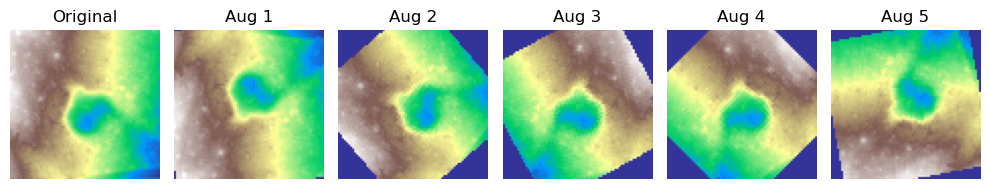

In [4]:
# === Prepare CD data ===

# Convert to torch tensors
cd_data_torch = torch.tensor(cd_data, dtype=torch.float32)
cd_labels_torch = torch.tensor(cd_labels, dtype=torch.long)
print(f"{'':<15} {'CD Data':<30} {'CD Labels':<30}")
print(f"{'Shape':<15} {str(cd_data_torch.shape):<30} {str(cd_labels_torch.shape):<30}")

base_dataset = TensorDataset(cd_data_torch, cd_labels_torch)

# Split into 70/30/0 for training/validation/testing
cd_ids = np.load("final_train_CD_id_norm.npy") # split taking CD cluster id into accound to avoid data leakage
val_perc = 0.3
test_perc = 0.0
train_dataset_cd, val_dataset_cd, test_dataset_cd = split_dataset(base_dataset, cd_ids, val_perc, test_perc)

# Perform data augmentation
augmented_train_dataset_cd = augment_dataset(train_dataset_cd, transform = augment_transform, n_augments=5)

# Print info 
print('\n')
print(f"{'':<30} {'Training':<30} {'Validation':<30} {'Testing':<30}")
print(f"{'Percentage of CD dataset':<30} {str(int((1-val_perc-test_perc)*100))+'%':<30} {str(int(val_perc*100))+'%':<30} {str(int(test_perc*100))+'%':<30}")
print(f"{'Number of CDs':<30} {str(len(train_dataset_cd)):<30} {str(len(val_dataset_cd)):<30} {str(len(test_dataset_cd)):<30}")
print(f"{'Number of augmented CDs':<30} {str(len(augmented_train_dataset_cd)-len(train_dataset_cd)):<30} {str('0'):<30} {str('0'):<30}")
plot_dem_with_augmentations(train_dataset_cd, sample_idx=22, n_augments=5)

In [ ]:
# === Prepare Non-CD data ===

# Convert to torch tensors
non_cd_data_torch = torch.from_numpy(non_cd_data).float()
non_cd_labels_torch = torch.tensor(non_cd_labels, dtype=torch.long)
print(f"{'':<15} {'Non-CD Data':<30} {'Non-CD Labels':<30}")
print(f"{'Shape':<15} {str(non_cd_data_torch.shape):<30} {str(non_cd_labels_torch.shape):<30}")

negative_dataset = TensorDataset(non_cd_data_torch, non_cd_labels_torch)

# Split into 70/30/0 for training/validation/testing
val_perc_neg = 0.3
test_perc_neg = 0.0
total_neg = len(negative_dataset)
val_size_neg = int(val_perc_neg * total_neg)
test_size_neg = int(test_perc_neg * total_neg)
train_size_neg = total_neg - val_size_neg - test_size_neg

train_dataset_non_cd, val_dataset_non_cd, test_dataset_non_cd = random_split(negative_dataset, 
                                                                    [train_size_neg, val_size_neg, test_size_neg], 
                                                                    generator=torch.Generator().manual_seed(42))

# Print info
print('\n')
print(f"{'':<30} {'Training':<30} {'Validation':<30} {'Testing':<30}")
print(f"{'Percentage of non-CD dataset':<30} {str(int((1-val_perc_neg-test_perc_neg)*100))+'%':<30} {str(int(val_perc_neg*100))+'%':<30} {str(int(test_perc_neg*100))+'%':<30}")
print(f"{'Number of non-CDs':<30} {str(len(train_dataset_non_cd)):<30} {str(len(val_dataset_non_cd)):<30} {str(len(test_dataset_non_cd)):<30}")

                Non-CD Data                    Non-CD Labels                 
Shape           torch.Size([111871, 3, 74, 74]) torch.Size([111871])          


                               Training                       Validation                     Testing                       
Percentage of non-CD dataset   70%                            30%                            0%                            
Number of non-CDs              78310                          33561                          0                             


In [6]:
# === Functions: Data loaders ===
def get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset):
    batch_size = 32
    
    # Compute class weights for sampler
    y_train = []
    for data in final_train_dataset:
        _, y = data
        y_train.append(y)
    y_train = torch.tensor(y_train)

    # Calculate class counts and weights
    class_counts = torch.bincount(y_train)
    class_weights = 1. / class_counts.float()
    sample_weights = class_weights[y_train]
    
    # Weighted random sampler for imbalanced data
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    # Create DataLoaders with samplers
    train_loader = DataLoader(final_train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [7]:
# === Combine CD & Non-CD data ===

# Create DataLoaders
final_train_dataset = ConcatDataset([augmented_train_dataset_cd, train_dataset_non_cd])
final_val_dataset = ConcatDataset([val_dataset_cd, val_dataset_non_cd])
final_test_dataset = ConcatDataset([test_dataset_cd, test_dataset_non_cd])

print(f"{'':<30} {'Training':<30} {'Validation':<30} {'Testing':<30}")
print(f"{'Number of samples':<30} {str(len(final_train_dataset)):<30} {str(len(final_val_dataset)):<30} {str(len(final_test_dataset)):<30}")

                               Training                       Validation                     Testing                       
Number of samples              80164                          33693                          0                             


**Part II: Training and validating 2D CNN**

In [8]:
# === Functions: CNN ===
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
       
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(256*1*1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_classes)

        # Dropout layers
        self.dropout = nn.Dropout(0.4) # at least 0.4 for robustness

    def forward(self, x):
        # Convolutional layers with ReLU activation & batch normalization 
        # & Max pooling layers
        x = F.relu(self.bn1(self.conv1(x)))         # (batch, 32, 50, 50)
        x = F.relu(self.bn2(self.conv2(x)))         # (batch, 64, 50, 50)
        x = self.pool(x)                            # (batch, 64, 25, 25)
        
        x = F.relu(self.bn3(self.conv3(x)))         # (batch, 128, 25, 25)
        x = F.relu(self.bn4(self.conv4(x)))         # (batch, 256, 25, 25)
        x = self.pool(x)                            # (batch, 256, 12, 12)

        # Average pooling layer
        x = self.global_pool(x)                     # (batch, 256, 1, 1)
        
        # Flatten
        x = torch.flatten(x, 1)                     # (batch, 256)

        # Fully connected layers with ReLU activation 
        # & Dropout layers
        x = self.dropout(F.relu(self.fc1(x)))      # (batch, 128)
        x = self.dropout(F.relu(self.fc2(x)))      # (batch, 64)
        x = self.output(x)                         # (batch, 1)

        return x

In [ ]:
# === Set device ===
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = CNN().to(device)
print(f"Device will run on {device}")

In [ ]:
# === Training and validation === 

# Hyperparameters
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
threshold = 0.33
n_epochs = 50
batch_size = 32
patience = 8

# Load data
train_loader, val_loader, _ = get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset)

# Compute class weights
train_labels = torch.cat([target for _, target in train_loader], dim=0)
pos_count = (train_labels == 1).sum().item()
neg_count = (train_labels == 0).sum().item()
pos_weight = torch.tensor([neg_count / pos_count]).to(device)

# Weighted binary classification loss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

best_f1 = 0.0
best_epoch_data = None
epochs_no_improve = 0
best_model_state = None
f1_scores, precisions, recalls, pr_aucs = [], [], [], []
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
train_correct, val_correct = [], []

start_time = time.time()

for epoch in tqdm(range(n_epochs), desc="Training"):
    # Training
    train_loss = 0.0    # loss per epoch
    train_corr = 0      # number of correct predictions per epoch
    model.train()       # set training mode
    for data, target in train_loader:
        data, target = data.to(device), target.to(device).float()   # get predictions from the training set
        output = model(data).squeeze(1)                             # compare predictions to actual labels
        loss = criterion(output, target)
        
        probs = torch.sigmoid(output)                               # apply sigmoid (only here so we can get exact predictions)
        preds = (probs >= threshold).long()
        
        train_corr += (preds == target.long()).sum().item()         # add up numbers of correct predictions
        train_loss += loss.item()                                   # add loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(train_loss / len(train_loader))
    train_correct.append(train_corr)

    # Validation
    val_loss = 0.0  # loss per epoch
    val_corr = 0    # number of correct predictions per epoch
    model.eval()    # set evaluation mode
    all_inputs, all_preds, all_targets, all_probs = [], [], [], []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device).float()
            output = model(data).squeeze(1)
            loss = criterion(output, target)

            probs = torch.sigmoid(output)
            preds = (probs >= threshold).long()

            val_corr += (preds == target.long()).sum().item()
            val_loss += loss.item()

            all_inputs.extend(data.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_correct.append(val_corr)

    # Compute F1 score
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    
    # Compute other metrics
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_probs)
    pr_auc = auc(recall_curve, precision_curve)

    # Store metrics
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    pr_aucs.append(pr_auc)
    train_accuracies.append(train_corr / len(train_loader.dataset))
    val_accuracies.append(val_corr / len(val_loader.dataset))

    print("\n" + "="*50)
    print(f"Epoch {epoch+1}/{n_epochs}")
    print("-"*50)
    print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]* 100:.2f}%")
    print(f"Val Loss:   {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]* 100:.2f}%")
    print(f"Precision:  {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f} | PR-AUC: {pr_auc:.4f}")
    print("="*50)

    # Early stopping based on F1
    if f1 > best_f1 + 1e-4:
        best_f1 = f1
        best_epoch_data = {
            "inputs": all_inputs.copy(),
            "probs": all_probs.copy(),
            "targets": all_targets.copy(),
            "epoch": epoch}        
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print("New best model saved!")
    else:
        epochs_no_improve += 1
        print(f"No improvement in F1 for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered. Best F1: {best_f1:.4f}")
        break

# Save best model
if best_model_state is not None:
    model_path = "cnn_2d_final_run.pt"
    torch.save(best_model_state, model_path)
    print("\nBest model saved to cnn_2d_final_run.pt")

# Stop time
current_time = time.time()
training_time = (current_time - start_time)/60
print(f"\nTraining completed in {np.round(training_time)} minutes.")

In [ ]:
# === Plot figures ===
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(16, 10))

# Plot 1: Losses
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label=f"Train", alpha=0.6, color='#2a9d8f' , linewidth= 2)
plt.plot(epochs, val_losses, label=f"Val", linestyle="--", alpha=0.6, color='#2a9d8f', linewidth=1)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize="small")

# Plot 2: Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label=f"Train", alpha=0.6, color='#2a9d8f' , linewidth= 2)
plt.plot(epochs, val_accuracies, label=f"Val", linestyle="--", alpha=0.6, color='#2a9d8f', linewidth=1)
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(fontsize="small")

# Plot 3: F1 only
plt.subplot(2, 2, 3)
#smoothed_f1_scores = savgol_filter(f1_scores, window_length=3, polyorder=2)
plt.plot(epochs, f1_scores, label=f"Val", alpha=0.7, color='#2a9d8f', linewidth=2)
plt.title("F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend(fontsize="small")

# Plot 4: PR AUC
plt.subplot(2, 2, 4)
#smoothed_pr_aucs = savgol_filter(pr_aucs, window_length=3, polyorder=2)
plt.plot(epochs, pr_aucs, label=f"Val", alpha=0.7, color='#2a9d8f', linewidth=2)
plt.title("Precision-Recall AUC")
plt.xlabel("Epoch")
plt.ylabel("PR-AUC")
plt.legend(fontsize="small")

plt.tight_layout()
plt.show()

In [9]:
# === Load them model ===
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device will run on {device}")

model = CNN().to(device)
model.load_state_dict(torch.load("cnn_2d_final_run.pt"))

Device will run on cuda


<All keys matched successfully>

In [ ]:
# Hyperparameters
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
threshold = 0.33
batch_size = 32

# Load data
train_loader, val_loader, _ = get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset)

# Compute class weights
train_labels = torch.cat([target for _, target in train_loader], dim=0)
pos_count = (train_labels == 1).sum().item()
neg_count = (train_labels == 0).sum().item()
pos_weight = torch.tensor([neg_count / pos_count]).to(device)

# Weighted binary classification loss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


f1_scores, precisions, recalls, pr_aucs = [], [], [], []
val_accuracies = []
val_losses = []
val_correct = []

# Validation
val_loss = 0.0  # loss per epoch
val_corr = 0    # number of correct predictions per epoch
model.eval()    # set evaluation mode
all_inputs, all_preds, all_targets, all_probs = [], [], [], []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device).float()
        output = model(data).squeeze(1)
        loss = criterion(output, target)

        probs = torch.sigmoid(output)
        preds = (probs >= threshold).long()

        val_corr += (preds == target.long()).sum().item()
        val_loss += loss.item()

        all_inputs.extend(data.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

val_losses.append(val_loss / len(val_loader))
val_correct.append(val_corr)

# Compute F1 score
f1 = f1_score(all_targets, all_preds, zero_division=0)

# Compute other metrics
precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)
precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_probs)
pr_auc = auc(recall_curve, precision_curve)

# Store metrics
f1_scores.append(f1)
precisions.append(precision)
recalls.append(recall)
pr_aucs.append(pr_auc)
val_accuracies.append(val_corr / len(val_loader.dataset))

print(f"Val Loss:   {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]* 100:.2f}%")
print(f"Precision:  {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f} | PR-AUC: {pr_auc:.4f}")


Val Loss:   0.0209 | Val Acc: 99.19%
Precision:  0.1921 | Recall: 0.3333 | F1 Score: 0.2438 | PR-AUC: 0.1401


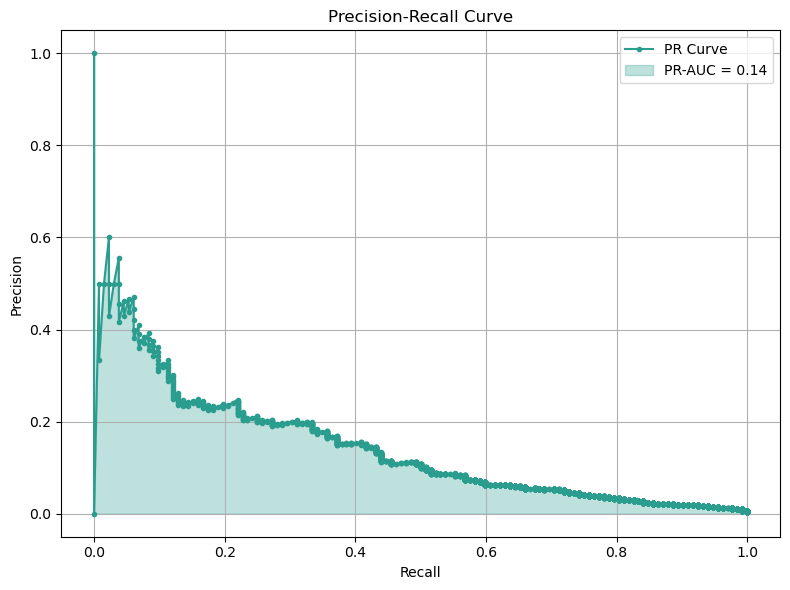

In [10]:
# Hyperparameters
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
threshold = 0.16
batch_size = 32

# Load data
train_loader, val_loader, _ = get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset)

# Compute class weights
train_labels = torch.cat([target for _, target in train_loader], dim=0)
pos_count = (train_labels == 1).sum().item()
neg_count = (train_labels == 0).sum().item()
pos_weight = torch.tensor([neg_count / pos_count]).to(device)

# Weighted binary classification loss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


f1_scores, precisions, recalls, pr_aucs = [], [], [], []
val_accuracies = []
val_losses = []
val_correct = []

# Validation
val_loss = 0.0  # loss per epoch
val_corr = 0    # number of correct predictions per epoch
model.eval()    # set evaluation mode
all_inputs, all_preds, all_targets, all_probs = [], [], [], []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device).float()
        output = model(data).squeeze(1)
        loss = criterion(output, target)

        probs = torch.sigmoid(output)
        preds = (probs >= threshold).long()

        val_corr += (preds == target.long()).sum().item()
        val_loss += loss.item()

        all_inputs.extend(data.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

val_losses.append(val_loss / len(val_loader))
val_correct.append(val_corr)

# Compute F1 score
f1 = f1_score(all_targets, all_preds, zero_division=0)

# Compute other metrics
precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)
precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_probs)
pr_auc = auc(recall_curve, precision_curve)

# Store metrics
f1_scores.append(f1)
precisions.append(precision)
recalls.append(recall)
pr_aucs.append(pr_auc)
val_accuracies.append(val_corr / len(val_loader.dataset))

print(f"Val Loss:   {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]* 100:.2f}%")
print(f"Precision:  {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f} | PR-AUC: {pr_auc:.4f}")

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, marker='.', color='#2a9d8f', label='PR Curve')
plt.fill_between(recall_curve, precision_curve, color='#2a9d8f', alpha=0.3, label=f'PR-AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# === Functions: Visualize predictions ===
def visualize_predictions(inputs, targets, preds, max_per_group=10):
    tp, fp, fn = [], [], []

    for i in range(len(inputs)):
        input_img = inputs[i]
        true = targets[i].item()
        pred = preds[i].item()

        if true == 1 and pred == 1:
            tp.append(input_img)
        elif true == 0 and pred == 1:
            fp.append(input_img)
        elif true == 1 and pred == 0:
            fn.append(input_img)

    def plot_group(imgs, title, n=max_per_group):
        n = min(len(imgs), n)
        fig, axs = plt.subplots(1, n, figsize=(n * 2, 2))
        fig.suptitle(title)
        for i in range(n):
            img = imgs[i+8][0]
            axs[i].imshow(img, cmap='terrain')
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()

    plot_group(tp, "True Positives")
    plot_group(fp, "False Positives")
    plot_group(fn, "False Negatives")


In [ ]:
# === Plots ===
# F1 vs. threshold
#all_inputs = np.array(best_epoch_data["inputs"])
#all_probs = np.array(best_epoch_data["probs"])
#all_targets = np.array(best_epoch_data["targets"])

thresholds = np.linspace(0.01, 0.99, 100)
f1s = [f1_score(all_targets, (all_probs >= t)) for t in thresholds]

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s, label="F1 Score", color="#2a9d8f")
plt.title("F1 Score vs. Threshold (Best Epoch)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()

# Visualize predictions
visualize_predictions(all_inputs, all_targets, all_preds)

In [ ]:
# === Functions: Visualize feature maps === 

def plot_feature_maps(activation, layer_name='conv1', num_cols=8):
    activation = activation.squeeze(0)  # (C, H, W)
    activation_np = activation.detach().cpu().numpy()

    num_channels = activation_np.shape[0]
    num_to_show = num_cols

    indices = np.linspace(0, num_channels - 1, num=num_to_show, dtype=int)

    num_rows = (num_to_show + num_cols - 1) // num_cols
    plt.figure(figsize=(num_cols * 2, num_rows * 2))

    for i, channel_idx in enumerate(indices):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(activation_np[channel_idx], cmap='viridis')
        plt.axis('off')
        #plt.title(f'C{channel_idx}', fontsize=8)

    plt.suptitle(f'{layer_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# === Visualise feature maps ===

# Dictionary to store feature maps
feature_maps = OrderedDict()

# Register hooks to capture the feature maps
def hook_fn(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

# Register hooks on convolutional layers
model.conv1.register_forward_hook(hook_fn('conv1'))
model.conv2.register_forward_hook(hook_fn('conv2'))
model.conv3.register_forward_hook(hook_fn('conv3'))
model.conv4.register_forward_hook(hook_fn('conv4'))

def preprocess_image(image_np):
    image_tensor = torch.from_numpy(image_np).squeeze(0)  # (1, 3, H, W)
    return image_tensor

image_np = np.load("final_train_CD_features_norm.npy")

input_tensor = preprocess_image(image_np).to(device)

# Forward pass
with torch.no_grad():
    _ = model(input_tensor)

# Display part of feature maps
for layer_name, activation in feature_maps.items():
    plot_feature_maps(activation[20], layer_name, 5)
